In [5]:
import pandas as pd
import numpy as np
from spacy.en import English
nlp = English()
import random
from sklearn.metrics.pairwise import cosine_similarity
import math
import matplotlib.pyplot as plt
%matplotlib inline

import psycopg2 as pg2
import psycopg2.extras as pgex
this_host='34.211.59.66'
this_user='postgres'
this_password='postgres'
conn = pg2.connect(host = this_host, 
                        user = this_user,
                        password = this_password)

sql_select = '''select created_at, tweet_content, cleaned_tweet from tweets;'''

cur = conn.cursor(cursor_factory=pgex.RealDictCursor)
cur.execute(sql_select)
rows = cur.fetchall()
conn.close()
df = pd.DataFrame(rows)

In [6]:
def event_tweet_count(event):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    return len(event_tweet)

In [7]:
def tweets_event_ab_test(event, n = 200):
    event_tweet = df[df['cleaned_tweet'].str.contains((event))]
    event_tweet.reset_index(inplace = True)
    
    A_index = list(range(event_tweet.shape[0]))
    random.shuffle(A_index)
    
    n = n
    A1_index = []
    for i in range(n):
        A1_index.append(A_index.pop())
    
    A1 = event_tweet.iloc[A1_index,:]
    A1.reset_index(inplace = True)
    A1_vec = np.array([nlp(i).vector for i in A1['cleaned_tweet']])
    
    A2 = event_tweet.iloc[A_index,:] 
    A2.reset_index(inplace = True)
    A2_vec = np.array([nlp(i).vector for i in A2['cleaned_tweet']])
    non_event_tweet = df[~df['cleaned_tweet'].str.contains(('event'))]
    non_event_tweet.reset_index(inplace = True)
    
    B_index = list(range(non_event_tweet.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
    m = A2.shape[0]
    B2_index = []
    for i in range(m):
        B2_index.append(B_index.pop())  
    
    
    B1 = non_event_tweet.iloc[B1_index,:]
    B1.reset_index(inplace = True)
    B1_vec = np.array([nlp(i).vector for i in B1['cleaned_tweet']])
    
    B2 = non_event_tweet.iloc[B2_index,:]
    B2.reset_index(inplace = True)
    B2_vec = np.array([nlp(i).vector for i in B2['cleaned_tweet']])
    
    A1_vec_mean = np.average(A1_vec, axis=0)
    A2_vec_mean = np.average(A2_vec, axis=0)
    B1_vec_mean = np.average(B1_vec, axis=0)
    B2_vec_mean = np.average(B2_vec, axis=0)
    
    a1a2 = cosine_similarity(A1_vec_mean.reshape(1,-1),A2_vec_mean.reshape(1,-1))[0][0]
    b1b2 = cosine_similarity(B2_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a1b1 = cosine_similarity(A1_vec_mean.reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0]
    a2b2 = cosine_similarity(A2_vec_mean.reshape(1,-1),B2_vec_mean.reshape(1,-1))[0][0]
   
    a2_consim_list = []
    for i in range(min(n,m)):  
        a2_consim_list.append(cosine_similarity(A2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0])
    a2_mean = np.mean(np.array(a2_consim_list))
    a2_std = np.std(np.array(a2_consim_list))
    
    b2_consim_list = []
    for i in range(min(n,m)):  
        b2_consim_list.append(cosine_similarity(B2_vec[i].reshape(1,-1),B1_vec_mean.reshape(1,-1))[0][0])
    b2_mean = np.mean(b2_consim_list)
    b2_std = np.std(b2_consim_list)
    
    a1b2_consim_list = []
    for i in range(min(n,m)):  
        a1b2_consim_list.append((cosine_similarity(B2_vec[i].reshape(1,-1),A1_vec_mean.reshape(1,-1))[0][0]))
    a1b2_mean = np.mean(a1b2_consim_list)
    a1b2_std = np.std(a1b2_consim_list)
    
    print('A1|A2: ',a1a2,'\n'
                'B1|B2: ',b1b2, '\n\n'
                'A1|B1: ',a1b1, '\n'
                'A2|B2: ', a2b2, '\n\n'
                'Cosine Similarity Mean of A2 to A1', a2_mean, '\n'
                'Cosine Similarity Mean of B2 to B1', b2_mean, '\n'
                'Cosine Similarity Mean of B2 to A1', a1b2_mean, '\n\n'
                'Cosine Similarity STD of A2 to A1', a2_std, '\n'
                'Cosine Similarity STD of B2 to B1', b2_std, '\n'
                'Cosine Similarity STD of B2 to A1', a1b2_std, '\n'                 
                )
    
    return a2_consim_list, b2_consim_list

In [16]:
def Top_tweets_in_b(event, n = 200):
    A = df[df['cleaned_tweet'].str.contains((event))]
    A.reset_index(inplace = True)
    A_vec = np.array([nlp(i).vector for i in A['cleaned_tweet']])
    A_vec_mean = np.average(A_vec, axis=0)
    
    
    B = df[~df['cleaned_tweet'].str.contains(('event'))]
    B.reset_index(inplace = True)
    
    B_index = list(range(B.shape[0]))
    random.shuffle(B_index)
    n = n
    B1_index = []
    for i in range(n):
        B1_index.append(B_index.pop())
   
        
    B1 = B.iloc[B1_index,:]
    B1.reset_index(inplace = True)
    B1_vec = np.array([nlp(i).vector for i in B1['cleaned_tweet']])
    
    
    consim_twt_list = []
    for i in range(n):  
        consim_twt_list.append((cosine_similarity(B1_vec[i].reshape(1,-1),A_vec_mean.reshape(1,-1))[0][0], B1['cleaned_tweet'][i]))
    pd.options.display.max_colwidth = 200
    result = pd.DataFrame(consim_twt_list, columns = ['score','tweet'])
    print(result.shape)
    result = result[result['score']>.95]
    result.sort_values('score', axis = 0, ascending = False)
    return result['tweet'].values

Event Tweets (A):  2529
A1|A2:  0.99946 
B1|B2:  0.999183 

A1|B1:  0.975828 
A2|B2:  0.973948 

Cosine Similarity Mean of A2 to A1 0.891954 
Cosine Similarity Mean of B2 to B1 0.843705 
Cosine Similarity Mean of B2 to A1 0.825285 

Cosine Similarity STD of A2 to A1 0.0902695 
Cosine Similarity STD of B2 to B1 0.140911 
Cosine Similarity STD of B2 to A1 0.137944 



(-0.1, 1)

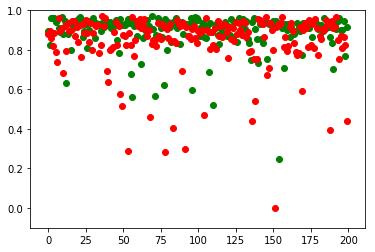

In [8]:
print('Event Tweets (A): ', event_tweet_count('paris|climate'))
A, B = tweets_event_ab_test('paris|climate', n = 200)
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1)

Event Tweets (A):  891
A1|A2:  0.999089 
B1|B2:  0.999081 

A1|B1:  0.947692 
A2|B2:  0.941522 

Cosine Similarity Mean of A2 to A1 0.883742 
Cosine Similarity Mean of B2 to B1 0.828579 
Cosine Similarity Mean of B2 to A1 0.79324 

Cosine Similarity STD of A2 to A1 0.0681132 
Cosine Similarity STD of B2 to B1 0.159922 
Cosine Similarity STD of B2 to A1 0.138652 



(-0.1, 1.2)

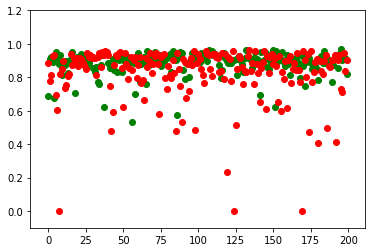

In [9]:
print('Event Tweets (A): ', event_tweet_count('nbafinal'))
A, B = tweets_event_ab_test('nbafinals', n = 200)
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

Event Tweets (A):  200
A1|A2:  0.997264 
B1|B2:  0.99504 

A1|B1:  0.964011 
A2|B2:  0.960974 

Cosine Similarity Mean of A2 to A1 0.905588 
Cosine Similarity Mean of B2 to B1 0.849429 
Cosine Similarity Mean of B2 to A1 0.828775 

Cosine Similarity STD of A2 to A1 0.0653177 
Cosine Similarity STD of B2 to B1 0.135647 
Cosine Similarity STD of B2 to A1 0.136235 



(-0.1, 1.2)

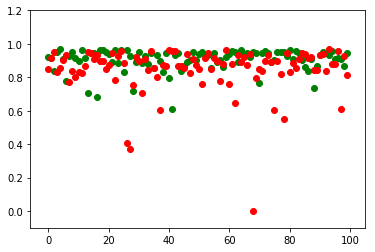

In [10]:
print('Event Tweets (A): ', event_tweet_count('travel ban|travelban'))
A, B = tweets_event_ab_test('travel ban|travelban', n = 100)
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

Event Tweets (A):  527
A1|A2:  0.998137 
B1|B2:  0.998347 

A1|B1:  0.93367 
A2|B2:  0.91555 

Cosine Similarity Mean of A2 to A1 0.873418 
Cosine Similarity Mean of B2 to B1 0.816405 
Cosine Similarity Mean of B2 to A1 0.76242 

Cosine Similarity STD of A2 to A1 0.0614424 
Cosine Similarity STD of B2 to B1 0.193445 
Cosine Similarity STD of B2 to A1 0.165231 



(-0.1, 1.2)

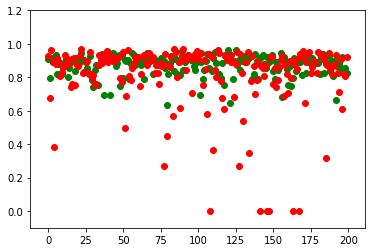

In [11]:
print('Event Tweets (A): ', event_tweet_count('nationaldonutday'))
A, B = tweets_event_ab_test('nationaldonutday', n = 200)
plt.scatter(range(len(A)), A, c = 'g')
plt.scatter(range(len(B)), B, c = 'r')
plt.ylim(-.1,1.2)

In [17]:
Top_tweets_in_b('paris|climate', n = 15000)

(15000, 2)


array([ "hey i'm a consumer and like the new site, but this is no way to build revenue and trust with… ",
       "i'm going to sleep now. wake your asses up &amp; focus on banding together. this is the beginning of the end ofus unl… ",
       "big sean is a bitch lol. how did you start a beef and go so long without responding to the response that we've forgotten altogether",
       'trump is more than a stain on our great nation. he is a curse. please hurry, investigators, so we can be rid of him b4 he damages us more.',
       'and the right has done what? mrs. diss obama repeatedly. how is it obama got more done with a republican congress… ',
       ' yeah, wtf is up with that? come on matt - we expect better of our assemblymembers… ',
       "last night's closing reception was a very good exercise in public speaking. it pays to have memorized what your vision really is.",
       "dinner with the fam! with all of us spread out, it doesn't happen often. #itsagoodnight ",
       "ok wo

In [18]:
Top_tweets_in_b('nationaldonutday', n = 15000)

(15000, 2)


array([ 'every single day i spend with them is the best day ever! #family #qualitytime #familynight #truelove #santamonica… ',
       'a dame that knows the ropes isn’t likely to get tied up. - #maewest #womeninhorror #actress #photography #g113 ',
       "there's #never #been a #terroristattack at a #nudist #colony. nudists aren't armed. they're nude. draw your own con… ",
       'what an honor to lead meditation this am thank you to everyone who showed up! #greentreeyogala #meditate #namaste #friends',
       'it never gets old with this view ... #laketahoe #outsideisfree #blackandwhite @ inspiration point ',
       'why yes, of course i need this $448 tote! ⚾️ #inmytotedreams #dooneyandbourke #dodgers… ',
       '#betweekend gone be #lit the #teamsmokegoodeatgood way  come party  june 25th!! with special… ',
       "it's about to go down! #lhsgrad2017 #gvusdshares ",
       'my #family like #toyota my #wife picking me up to have #lunch together she has a #2008 #toyota… ',
       'no